In [12]:
import pandas as pd

data = pd.read_csv("Electric_Production.csv")

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from sklearn.model_selection import train_test_split

In [58]:
# Load your data
data = pd.read_csv('Electric_Production.csv')

# Convert 'DATE' to datetime
data['DATE'] = pd.to_datetime(data['DATE'])

# Extract the target variable (e.g., 'IPG2211A2N')
target = data['IPG2211A2N'].values

In [59]:
# Normalize the target variable
scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaled = scaler.fit_transform(target.reshape(-1, 1))

# Create sequences for LSTM (sequence_length determines how many previous timesteps are used to predict the future)
sequence_length = 10

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Create sequences of data
sequences, labels = create_sequences(target_scaled, sequence_length)

In [60]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

# Convert the data into torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [62]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Get the last output from the sequence
        out = self.fc(out)
        return out

# Instantiate the model
model_no_attention = LSTMModel()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_no_attention.parameters(), lr=0.001)


In [63]:
num_epochs = 300

for epoch in range(num_epochs):
    model_no_attention.train()
    output = model_no_attention(X_train)
    loss = criterion(output, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/300], Loss: 0.1361
Epoch [20/300], Loss: 0.1042
Epoch [30/300], Loss: 0.0526
Epoch [40/300], Loss: 0.0509
Epoch [50/300], Loss: 0.0515
Epoch [60/300], Loss: 0.0507
Epoch [70/300], Loss: 0.0501
Epoch [80/300], Loss: 0.0498
Epoch [90/300], Loss: 0.0497
Epoch [100/300], Loss: 0.0495
Epoch [110/300], Loss: 0.0493
Epoch [120/300], Loss: 0.0491
Epoch [130/300], Loss: 0.0488
Epoch [140/300], Loss: 0.0483
Epoch [150/300], Loss: 0.0474
Epoch [160/300], Loss: 0.0451
Epoch [170/300], Loss: 0.0380
Epoch [180/300], Loss: 0.0354
Epoch [190/300], Loss: 0.0311
Epoch [200/300], Loss: 0.0302
Epoch [210/300], Loss: 0.0292
Epoch [220/300], Loss: 0.0287
Epoch [230/300], Loss: 0.0282
Epoch [240/300], Loss: 0.0277
Epoch [250/300], Loss: 0.0272
Epoch [260/300], Loss: 0.0267
Epoch [270/300], Loss: 0.0263
Epoch [280/300], Loss: 0.0259
Epoch [290/300], Loss: 0.0255
Epoch [300/300], Loss: 0.0251


In [64]:
model_no_attention.eval()
with torch.no_grad():
    predictions = model_no_attention(X_test)

# Rescale predictions back to the original range
predicted_values = scaler.inverse_transform(predictions.numpy())
actual_values = scaler.inverse_transform(y_test.numpy())


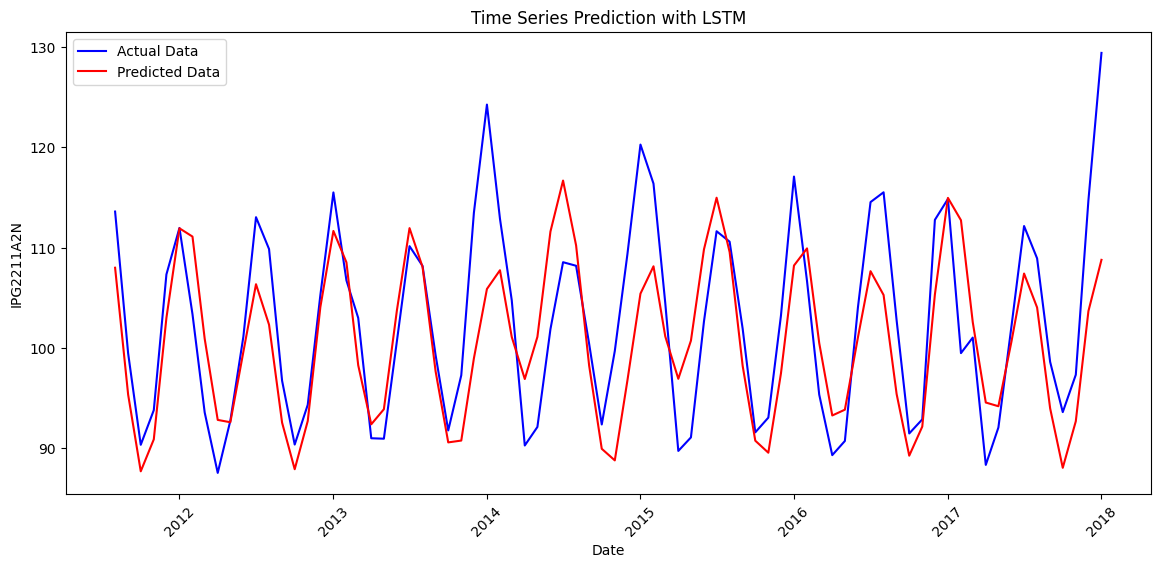

In [65]:
# Plot the original data and predictions
plt.figure(figsize=(14, 6))
plt.plot(data['DATE'].iloc[-len(y_test):].values, actual_values, label='Actual Data', color='blue')
plt.plot(data['DATE'].iloc[-len(y_test):].values, predicted_values, label='Predicted Data', color='red')
plt.xlabel('Date')
plt.ylabel('IPG2211A2N')
plt.title('Time Series Prediction with LSTM')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [66]:
import torch
import torch.nn as nn

# Attention Layer
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.attention_weight = nn.Parameter(torch.randn(hidden_size, 1))
        
    def forward(self, lstm_outputs):
        # Compute attention scores
        attn_scores = torch.matmul(lstm_outputs, self.attention_weight)
        attn_scores = torch.softmax(attn_scores, dim=1)  # Softmax over sequence length
        context_vector = torch.sum(attn_scores * lstm_outputs, dim=1)
        return context_vector


class LSTMWithAttentionModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMWithAttentionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the LSTM layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = AttentionLayer(hidden_size)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # First LSTM layer
        out, _ = self.lstm1(x, (h0, c0))
        
        # Apply attention after the first LSTM layer
        context_vector = self.attention(out)
        
        # Second LSTM layer (using the context vector as input)
        out, _ = self.lstm2(context_vector.unsqueeze(1).repeat(1, x.size(1), 1), (h0, c0))
        
        # Output layer
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [67]:
# Instantiate the model with attention
model_with_attention = LSTMWithAttentionModel()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_with_attention.parameters(), lr=0.001)

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    model_with_attention.train()
    output = model_with_attention(X_train)
    loss = criterion(output, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/300], Loss: 0.1467
Epoch [20/300], Loss: 0.1443
Epoch [30/300], Loss: 0.1268
Epoch [40/300], Loss: 0.0684
Epoch [50/300], Loss: 0.0575
Epoch [60/300], Loss: 0.0532
Epoch [70/300], Loss: 0.0504
Epoch [80/300], Loss: 0.0492
Epoch [90/300], Loss: 0.0485
Epoch [100/300], Loss: 0.0481
Epoch [110/300], Loss: 0.0475
Epoch [120/300], Loss: 0.0466
Epoch [130/300], Loss: 0.0444
Epoch [140/300], Loss: 0.0400
Epoch [150/300], Loss: 0.0302
Epoch [160/300], Loss: 0.0292
Epoch [170/300], Loss: 0.0268
Epoch [180/300], Loss: 0.0256
Epoch [190/300], Loss: 0.0246
Epoch [200/300], Loss: 0.0237
Epoch [210/300], Loss: 0.0242
Epoch [220/300], Loss: 0.0229
Epoch [230/300], Loss: 0.0219
Epoch [240/300], Loss: 0.0209
Epoch [250/300], Loss: 0.0197
Epoch [260/300], Loss: 0.0182
Epoch [270/300], Loss: 0.0187
Epoch [280/300], Loss: 0.0160
Epoch [290/300], Loss: 0.0132
Epoch [300/300], Loss: 0.0118


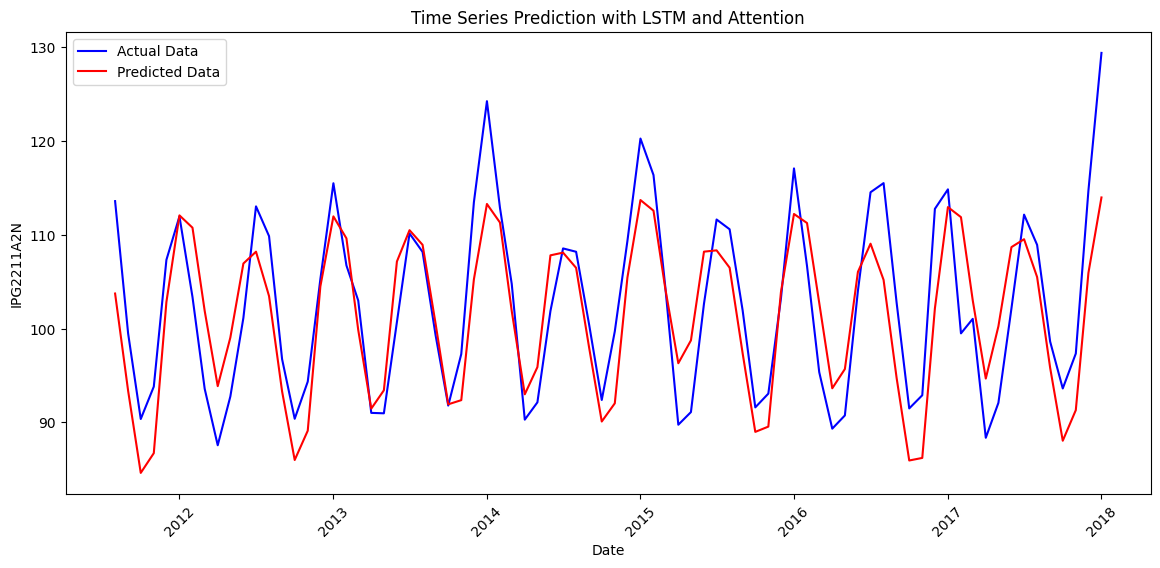

In [68]:
model_with_attention.eval()
with torch.no_grad():
    predictions = model_with_attention(X_test)

# Rescale predictions back to the original range
predicted_values = scaler.inverse_transform(predictions.numpy())
actual_values = scaler.inverse_transform(y_test.numpy())

# Visualize the data before and after prediction
plt.figure(figsize=(14, 6))
plt.plot(data['DATE'].iloc[-len(y_test):].values, actual_values, label='Actual Data', color='blue')
plt.plot(data['DATE'].iloc[-len(y_test):].values, predicted_values, label='Predicted Data', color='red')
plt.xlabel('Date')
plt.ylabel('IPG2211A2N')
plt.title('Time Series Prediction with LSTM and Attention')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [69]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_squared_error

# Function to train and evaluate both models
def train_and_evaluate(model1, model2, X_train, y_train, X_test, y_test, criterion, optimizer, num_epochs=100):
    # Training the first model
    model1.train()
    for epoch in range(num_epochs):
        output = model1(X_train)
        loss = criterion(output, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluating the first model
    model1.eval()
    with torch.no_grad():
        predictions1 = model1(X_test)
    loss1 = mean_squared_error(y_test.numpy(), predictions1.numpy())

    # Training the second model
    model2.train()
    for epoch in range(num_epochs):
        output = model2(X_train)
        loss = criterion(output, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluating the second model
    model2.eval()
    with torch.no_grad():
        predictions2 = model2(X_test)
    loss2 = mean_squared_error(y_test.numpy(), predictions2.numpy())

    # Comparing the two models
    if loss1 < loss2:
        return model1, loss1
    else:
        return model2, loss2


In [72]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_no_attention = torch.optim.Adam(model_no_attention.parameters(), lr=0.001)
optimizer_with_attention = torch.optim.Adam(model_with_attention.parameters(), lr=0.001)

# Train and evaluate both models
best_model, best_loss = train_and_evaluate(model_no_attention, model_with_attention, X_train, y_train, X_test, y_test, criterion, optimizer_no_attention)

print(f'Best model is {best_model} has a MSE loss of: {best_loss}')

Best model is LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
) has a MSE loss of: 0.016720030456781387


In [ ]:
# RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


# GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [74]:
# Instantiate the model with attention
RNN_model = RNNModel()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(RNN_model.parameters(), lr=0.001)

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    RNN_model.train()
    output = RNN_model(X_train)
    loss = criterion(output, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/300], Loss: 0.0542
Epoch [20/300], Loss: 0.0396
Epoch [30/300], Loss: 0.0222
Epoch [40/300], Loss: 0.0178
Epoch [50/300], Loss: 0.0135
Epoch [60/300], Loss: 0.0122
Epoch [70/300], Loss: 0.0116
Epoch [80/300], Loss: 0.0110
Epoch [90/300], Loss: 0.0106
Epoch [100/300], Loss: 0.0103
Epoch [110/300], Loss: 0.0101
Epoch [120/300], Loss: 0.0099
Epoch [130/300], Loss: 0.0097
Epoch [140/300], Loss: 0.0095
Epoch [150/300], Loss: 0.0093
Epoch [160/300], Loss: 0.0091
Epoch [170/300], Loss: 0.0089
Epoch [180/300], Loss: 0.0087
Epoch [190/300], Loss: 0.0085
Epoch [200/300], Loss: 0.0083
Epoch [210/300], Loss: 0.0081
Epoch [220/300], Loss: 0.0078
Epoch [230/300], Loss: 0.0076
Epoch [240/300], Loss: 0.0074
Epoch [250/300], Loss: 0.0071
Epoch [260/300], Loss: 0.0069
Epoch [270/300], Loss: 0.0066
Epoch [280/300], Loss: 0.0065
Epoch [290/300], Loss: 0.0063
Epoch [300/300], Loss: 0.0062


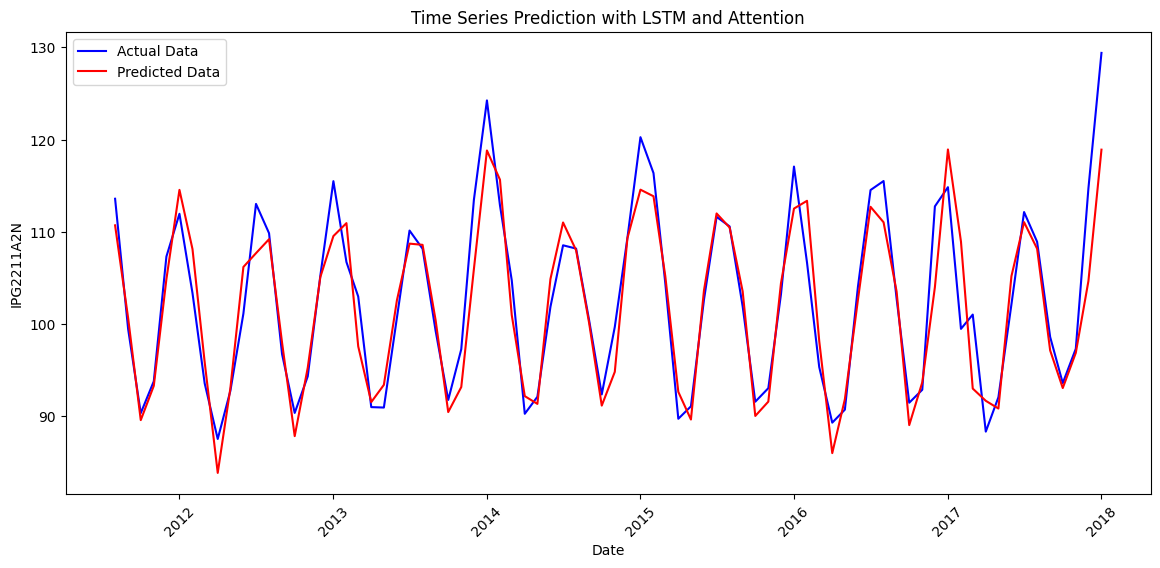

In [75]:
RNN_model.eval()
with torch.no_grad():
    predictions = RNN_model(X_test)

# Rescale predictions back to the original range
predicted_values = scaler.inverse_transform(predictions.numpy())
actual_values = scaler.inverse_transform(y_test.numpy())

# Visualize the data before and after prediction
plt.figure(figsize=(14, 6))
plt.plot(data['DATE'].iloc[-len(y_test):].values, actual_values, label='Actual Data', color='blue')
plt.plot(data['DATE'].iloc[-len(y_test):].values, predicted_values, label='Predicted Data', color='red')
plt.xlabel('Date')
plt.ylabel('IPG2211A2N')
plt.title('Time Series Prediction with LSTM and Attention')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [76]:
# Instantiate the model with attention
GRU_model = GRUModel()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(GRU_model.parameters(), lr=0.001)

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    GRU_model.train()
    output = GRU_model(X_train)
    loss = criterion(output, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/300], Loss: 0.1118
Epoch [20/300], Loss: 0.0669
Epoch [30/300], Loss: 0.0543
Epoch [40/300], Loss: 0.0511
Epoch [50/300], Loss: 0.0514
Epoch [60/300], Loss: 0.0505
Epoch [70/300], Loss: 0.0503
Epoch [80/300], Loss: 0.0500
Epoch [90/300], Loss: 0.0497
Epoch [100/300], Loss: 0.0494
Epoch [110/300], Loss: 0.0490
Epoch [120/300], Loss: 0.0485
Epoch [130/300], Loss: 0.0479
Epoch [140/300], Loss: 0.0469
Epoch [150/300], Loss: 0.0456
Epoch [160/300], Loss: 0.0435
Epoch [170/300], Loss: 0.0402
Epoch [180/300], Loss: 0.0343
Epoch [190/300], Loss: 0.0235
Epoch [200/300], Loss: 0.0140
Epoch [210/300], Loss: 0.0117
Epoch [220/300], Loss: 0.0106
Epoch [230/300], Loss: 0.0097
Epoch [240/300], Loss: 0.0092
Epoch [250/300], Loss: 0.0089
Epoch [260/300], Loss: 0.0087
Epoch [270/300], Loss: 0.0085
Epoch [280/300], Loss: 0.0082
Epoch [290/300], Loss: 0.0080
Epoch [300/300], Loss: 0.0078


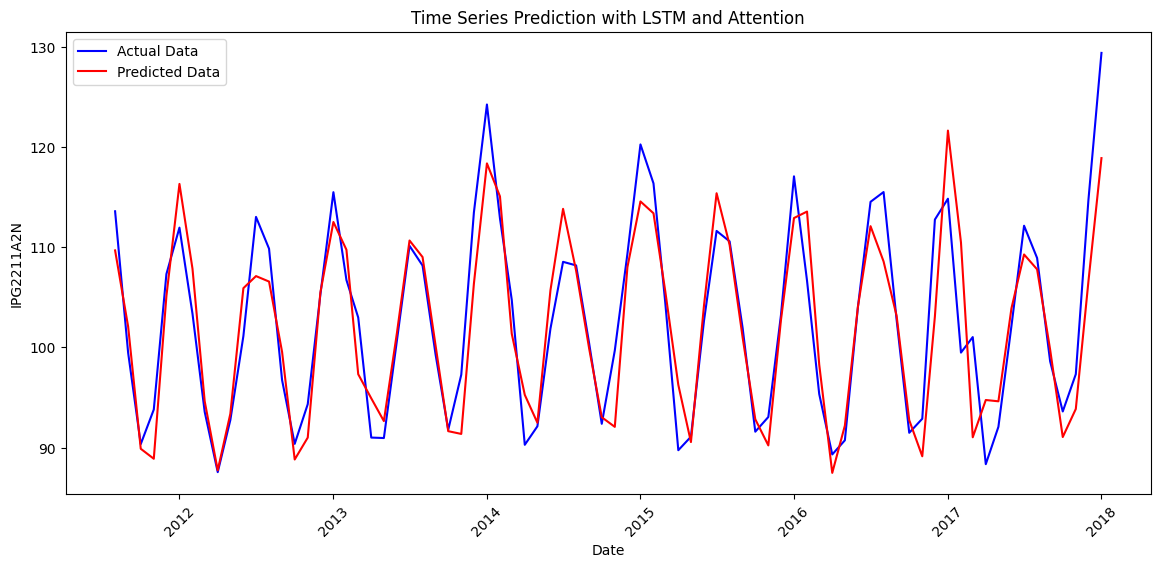

In [78]:
GRU_model.eval()
with torch.no_grad():
    predictions = GRU_model(X_test)

# Rescale predictions back to the original range
predicted_values = scaler.inverse_transform(predictions.numpy())
actual_values = scaler.inverse_transform(y_test.numpy())

# Visualize the data before and after prediction
plt.figure(figsize=(14, 6))
plt.plot(data['DATE'].iloc[-len(y_test):].values, actual_values, label='Actual Data', color='blue')
plt.plot(data['DATE'].iloc[-len(y_test):].values, predicted_values, label='Predicted Data', color='red')
plt.xlabel('Date')
plt.ylabel('IPG2211A2N')
plt.title('Time Series Prediction with LSTM and Attention')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [79]:
from sklearn.metrics import mean_squared_error

# Function to train and evaluate multiple models
def train_and_evaluate_all_models(models, X_train, y_train, X_test, y_test, criterion, optimizers, num_epochs=100):
    best_model = None
    best_loss = float('inf')
    
    for i, model in enumerate(models):
        optimizer = optimizers[i]
        
        # Training the model
        model.train()
        for epoch in range(num_epochs):
            output = model(X_train)
            loss = criterion(output, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Evaluating the model
        model.eval()
        with torch.no_grad():
            predictions = model(X_test)
        loss = mean_squared_error(y_test.numpy(), predictions.numpy())
        
        if loss < best_loss:
            best_loss = loss
            best_model = model
    
    return best_model, best_loss


In [80]:
# Assuming `X_train`, `y_train`, `X_test`, `y_test` are prepared and in the right format

# Instantiate models
model_lstm = LSTMModel()
model_lstm_attention = LSTMWithAttentionModel()
model_rnn = RNNModel()
model_gru = GRUModel()

# Create list of models
models = [model_lstm, model_lstm_attention, model_rnn, model_gru]

# Define loss function
criterion = nn.MSELoss()

# Define optimizers for each model
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
optimizer_lstm_attention = torch.optim.Adam(model_lstm_attention.parameters(), lr=0.001)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001)
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=0.001)

# Create list of optimizers
optimizers = [optimizer_lstm, optimizer_lstm_attention, optimizer_rnn, optimizer_gru]

# Train and evaluate all models
best_model, best_loss = train_and_evaluate_all_models(models, X_train, y_train, X_test, y_test, criterion, optimizers)

print(f"Best Model is {best_model} has MSE loss: {best_loss}")


Best Model is RNNModel(
  (rnn): RNN(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
) has MSE loss: 0.01575101912021637


In [81]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Function to train and evaluate multiple models with visualization
def train_and_evaluate_all_models(models, X_train, y_train, X_test, y_test, criterion, optimizers, num_epochs=100):
    model_losses = {}
    
    # Train and evaluate each model
    for i, model in enumerate(models):
        optimizer = optimizers[i]
        
        # Training the model
        model.train()
        for epoch in range(num_epochs):
            output = model(X_train)
            loss = criterion(output, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Evaluating the model
        model.eval()
        with torch.no_grad():
            predictions = model(X_test)
        loss = mean_squared_error(y_test.numpy(), predictions.numpy())
        
        # Store the loss for this model
        model_losses[type(model).__name__] = loss
    
    # Sort the models by loss (from best to worst)
    sorted_models = sorted(model_losses.items(), key=lambda x: x[1])

    # Visualize the results
    model_names = [model[0] for model in sorted_models]
    losses = [model[1] for model in sorted_models]

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(model_names, losses, color='skyblue')
    plt.xlabel('Mean Squared Error')
    plt.title('Model Performance Comparison')
    plt.gca().invert_yaxis()  # Highest performance at the top
    plt.show()
    
    # Return the best model (with the smallest MSE)
    best_model_name, best_loss = sorted_models[0]
    print(f"Best Model: {best_model_name} with MSE loss: {best_loss}")
    
    # Optionally, return the best model object if you need it
    best_model = [model for model in models if type(model).__name__ == best_model_name][0]
    return best_model, best_loss


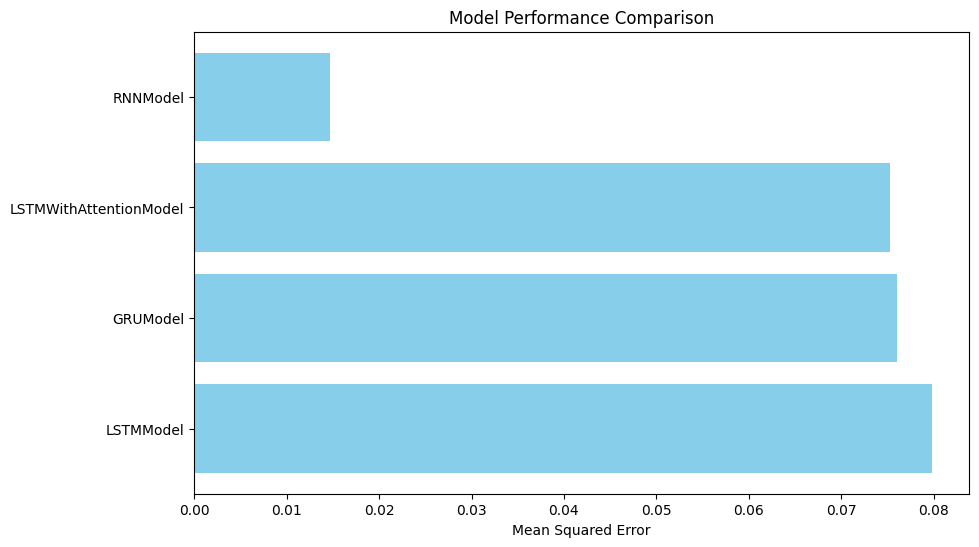

Best Model: RNNModel with MSE loss: 0.01466077845543623
Best Model: RNNModel with MSE loss: 0.01466077845543623


In [82]:
# Assuming `X_train`, `y_train`, `X_test`, `y_test` are prepared and in the right format

# Instantiate models
model_lstm = LSTMModel()
model_lstm_attention = LSTMWithAttentionModel()
model_rnn = RNNModel()
model_gru = GRUModel()

# Create list of models
models = [model_lstm, model_lstm_attention, model_rnn, model_gru]

# Define loss function
criterion = nn.MSELoss()

# Define optimizers for each model
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
optimizer_lstm_attention = torch.optim.Adam(model_lstm_attention.parameters(), lr=0.001)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001)
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=0.001)

# Create list of optimizers
optimizers = [optimizer_lstm, optimizer_lstm_attention, optimizer_rnn, optimizer_gru]

# Train and evaluate all models, also visualizing the results
best_model, best_loss = train_and_evaluate_all_models(models, X_train, y_train, X_test, y_test, criterion, optimizers)

# Optionally print the best model
print(f"Best Model: {type(best_model).__name__} with MSE loss: {best_loss}")


In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nhead=4, num_layers=2):
        super(TransformerModel, self).__init__()
        
        # Encoder layer (from nn.TransformerEncoder)
        self.embedding = nn.Linear(input_size, hidden_size)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_layers)
        
        # Output layer
        self.fc_out = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Transform input sequence to embeddings
        x = self.embedding(x)
        
        # Apply Transformer Encoder
        x = x.transpose(0, 1)  # Transformer expects (seq_len, batch_size, feature_size)
        x = self.transformer_encoder(x)
        
        # Use the output of the last time step for prediction (seq_len -> batch_size -> output)
        x = x[-1, :, :]  # Taking the last time step
        x = self.fc_out(x)
        return x


In [87]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Function to train and evaluate multiple models with visualization
def train_and_evaluate_all_models(models, X_train, y_train, X_test, y_test, criterion, optimizers, num_epochs=100):
    model_losses = {}
    
    # Train and evaluate each model
    for i, model in enumerate(models):
        optimizer = optimizers[i]
        
        # Training the model
        model.train()
        for epoch in range(num_epochs):
            output = model(X_train)
            loss = criterion(output, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Evaluating the model
        model.eval()
        with torch.no_grad():
            predictions = model(X_test)
        loss = mean_squared_error(y_test.numpy(), predictions.numpy())
        
        # Store the loss for this model
        model_losses[type(model).__name__] = loss
    
    # Sort the models by loss (from best to worst)
    sorted_models = sorted(model_losses.items(), key=lambda x: x[1])

    # Visualize the results
    model_names = [model[0] for model in sorted_models]
    losses = [model[1] for model in sorted_models]

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(model_names, losses, color='skyblue')
    plt.xlabel('Mean Squared Error')
    plt.title('Model Performance Comparison')
    plt.gca().invert_yaxis()  # Highest performance at the top
    plt.show()
    
    # Return the best model (with the smallest MSE)
    best_model_name, best_loss = sorted_models[0]
    print(f"Best Model: {best_model_name} with MSE loss: {best_loss}")
    
    # Optionally, return the best model object if you need it
    best_model = [model for model in models if type(model).__name__ == best_model_name][0]
    return best_model, best_loss


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


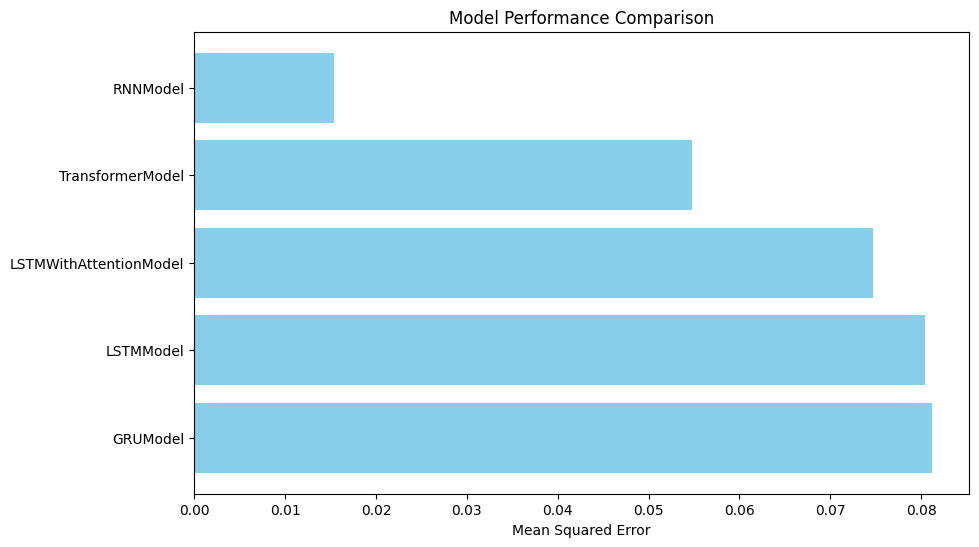

Best Model: RNNModel with MSE loss: 0.015349245630204678
Best Model: RNNModel with MSE loss: 0.015349245630204678


In [88]:
# Assuming `X_train`, `y_train`, `X_test`, `y_test` are prepared and in the right format

# Instantiate models
model_lstm = LSTMModel()
model_lstm_attention = LSTMWithAttentionModel()
model_rnn = RNNModel()
model_gru = GRUModel()
model_transformer = TransformerModel(input_size=X_train.shape[2], hidden_size=64, output_size=1)

# Create list of models
models = [model_lstm, model_lstm_attention, model_rnn, model_gru, model_transformer]

# Define loss function
criterion = nn.MSELoss()

# Define optimizers for each model
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
optimizer_lstm_attention = torch.optim.Adam(model_lstm_attention.parameters(), lr=0.001)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001)
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=0.001)
optimizer_transformer = torch.optim.Adam(model_transformer.parameters(), lr=0.001)

# Create list of optimizers
optimizers = [optimizer_lstm, optimizer_lstm_attention, optimizer_rnn, optimizer_gru, optimizer_transformer]

# Train and evaluate all models, also visualizing the results
best_model, best_loss = train_and_evaluate_all_models(models, X_train, y_train, X_test, y_test, criterion, optimizers)

# Optionally print the best model
print(f"Best Model: {type(best_model).__name__} with MSE loss: {best_loss}")
